# Behind the Nanaimo City Fire Incident Data

By [Andres Medina.](https://aamedinar.bitbucket.io/)

## tltr

A simple Exploratory data Anlysis for the open data set ***Fire Incidence*** from the city of Nanaimo is presented. Most of time, the fire department attends to *'Medical Aid'* calls.

## Preface

The city of Nanaimo in the Canadian province of Bristish Columbia, provides open access to some interesting data bases related to the city affairs. One of the most captivating data sets is the Nanaimo Fire Incident calls, it contains timestamps for the fire department calls received from the year 2005 to the present day along with a category field describing the type of call incident. Here, I learn about some of the city affairs by means of an analysis of this particular database.

The data is stored as a simple *SQLite* file (called **nfincidents.db**) and is included in this
repository. The database is automatically updated every day in order to keep up with the most recents events in the city.

## Data preliminaries

First, let's load the data into a *Python Pandas* **data frame**. Note that in this database schema, one of the fields is called *Timestamp* and contains the date and time of a particular incident call, we'll use it to index the data frame. The other relevant field is called *Description* and tells of the nature of the incident. We'll use it as a categorical field to explore the database itself.


In [86]:
import os
import warnings

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

# ignore warnings
warnings.filterwarnings("ignore")

class FireIncidentsProcessor:

    def __init__(self, db_name="nfincidents", table_name="incidents"):
        self.db_filename = db_name
        self.sqlite_table = table_name
        self.df = self.getDataFrame()

    def getDataFrame(self):
        df = None
        if os.path.exists(os.path.join("./", self.db_filename+".db")) and os.path.isfile(os.path.join("./", self.db_filename+".db")):
            cnx = sqlite3.connect(os.path.join("./", self.db_filename+".db"))
            df0 = pd.read_sql_query("SELECT * FROM {}".format(self.sqlite_table), cnx, index_col="index") # to eliminate posible duplicates, use call_id column
            df = preProcessIncidents(df0)
            #print(df.info())
        else:
            print("No existing database")
        return df

    def printInfo(self):
        # categories
        print("\n Incident description (categories)")
        for i, p in enumerate(self.df['Description'].cat.categories):
            print(i, p)
        print("\n",self.df['Description'].describe()) # count, unique, top, freq
        #
        print("\n\ttop call reason: {}".format(self.df['Description'].describe()['top']))
        print("\nfrom {}\n to {}".format(self.df.index.min(), self.df.index.max()))
        print("{} calls received".format(len(self.df.index)))

    def getFrequencySeries(self, target_colum='Description', sampling='day'):
        return self.df[target_colum].resample(sampling[0]).count() # y var

    def displaySimpleHist(self, ax=None):
        if ax == None:
            fig, ax = plt.subplots(constrained_layout=True, figsize=(5,6))
        cmap = cm.get_cmap('tab20') # chose a qualitative colormap
        colors = [cmap(i)[:-1]+tuple([0.75]) for i , s in enumerate(self.df['Description'].cat.categories)]
        self.df['Description'].value_counts().plot(ax = ax,
                                                  kind='bar',
                                                  color=colors)
        ax.set_xticklabels(self.df['Description'].value_counts().index, rotation=30, ha='right')
        ax.set_ylabel('counts')
        ax.grid(True)
        return ax

    def displaySimplePie(self, ax=None):
        # Pie chart, where the slices will be ordered and plotted counter-clockwise:
        labels = self.df['Description'].value_counts().index
        sizes = self.df['Description'].value_counts()
        cmap = cm.get_cmap('tab20') # chose a qualitative colormap
        colors = [cmap(i)[:-1]+tuple([0.6]) for i , s in enumerate(sizes)]
        #
        pcent = 100.*sizes/sizes.sum()
        labelled_pcent = ['{:.3f}% {:}'.format(p, l) for l, p in zip(labels, pcent)]
        if ax == None:
            fig, ax = plt.subplots(tight_layout=True, figsize=(10,6))
        out_ = ax.pie(sizes,
                wedgeprops=dict(width=0.5),
                shadow = False,
                colors = colors,
                startangle = 90,
                rotatelabels = True,)
        # get descriptor labels and percentage values 
        ax.legend(out_[0], labelled_pcent, loc='best', fontsize=8, bbox_to_anchor=(0.2, 1.))
        ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
        ax.set_title('Pie chart percentages')
        return ax


def preProcessIncidents(df, use_timestamp_index=True):
    # incident_desrciption to categories
    df['Description'] = df['Description'].astype('category')
    # use datetime column as index
    if use_timestamp_index:
        df['Timestamp'] = pd.to_datetime(df['Timestamp'])
        df.set_index('Timestamp', inplace=True)
    return df

# init processing unit
process = FireIncidentsProcessor()
process.printInfo()


 Incident description (categories)
0 Alarms Activated
1 Assistance
2 Burning Complaint
3 Bush Fire
4 Fire - Other
5 Hazardous Materials
6 Hydro Lines Down
7 Medical Aid
8 Motor Vehicle Incident
9 Rescue
10 Structure Fire

 count          109095
unique             11
top       Medical Aid
freq            68247
Name: Description, dtype: object

	top call reason: Medical Aid

from 2005-01-13 11:13:56+00:00
 to 2021-08-03 23:16:22+00:00
109095 calls received


# Categories bar plot

Using the 'Description' field, let's display a bar plot with the count of total incidents per category:


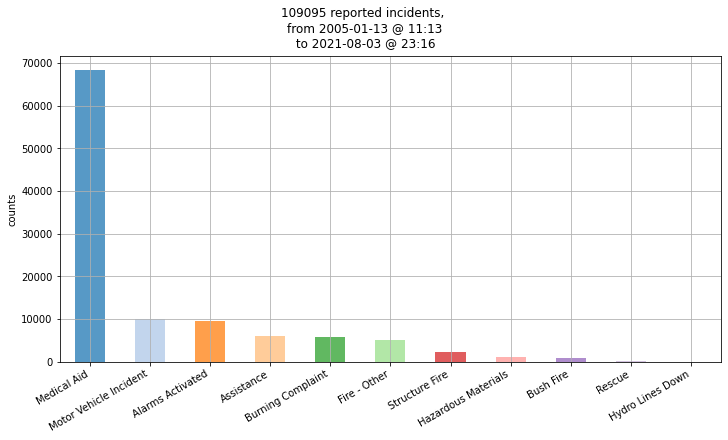

In [87]:
# Histogram
fig1 = plt.figure(figsize=(10, 6), constrained_layout=True)
fig1.suptitle('{} reported incidents, \nfrom {}\n to {}'.format(process.df.count()[0], process.df.index.min().strftime('%Y-%m-%d @ %H:%M'), process.df.index.max().strftime('%Y-%m-%d @ %H:%M')), fontsize=12)
#
ax1 = plt.subplot(111)
fig1.add_subplot(ax1)
ax1 = process.displaySimpleHist(ax=ax1)

# Yearly and monthly incidents count

As can be seen in the count chart per category, by far, most of the fire incident calls are 'Medical Aid' related. Yet, let us deepen into this count using the time index and display the resulting *time series* for the yearly and monthly count of fire calls.


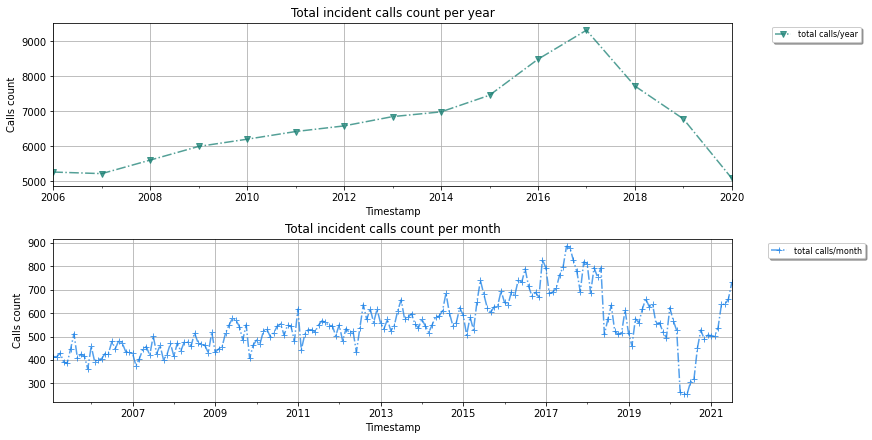

In [41]:
import random
random.seed(666)
fig_count = plt.figure(figsize=(12,6), constrained_layout=True)
samplings = ['year', 'month']
markers = ['v', '+']
for i, (sampling, marker) in enumerate(zip(samplings, markers)):
    # count of calls
    count = process.getFrequencySeries(sampling=sampling)[1:-1] # exclude last and first data points as they are incomplete
    # plot count
    ax_count = plt.subplot(len(samplings), 1, i+1)
    fig_count.add_subplot(ax_count)
    out = count.plot(ax=ax_count,
                   marker=marker,
                   linestyle='dashdot',
                   color = (0.1, 0.5, random.random(), 0.75),
                   title='Total incident calls count per {}'.format(sampling),
                   label='total calls/{}'.format(sampling))
    ax_count.set_ylabel('Calls count')
    ax_count.grid(True)
    tmp = ax_count.legend(loc='upper center', shadow=True, fontsize=8, bbox_to_anchor=(1.125, 1.))

As per COVID, I was expecting a clear and sharp decline in the number of calls received during 2020, and although this is the case as the number of calls for such year are even lower than the calls count in 2007, there is an interesting continous decline during 2018 and onwards for the number of yearly calls, after peaking in 2017. 

Let's see if this behaviour can be generalised across the reasons behind the calls by plotting the yearly count of calls per category.

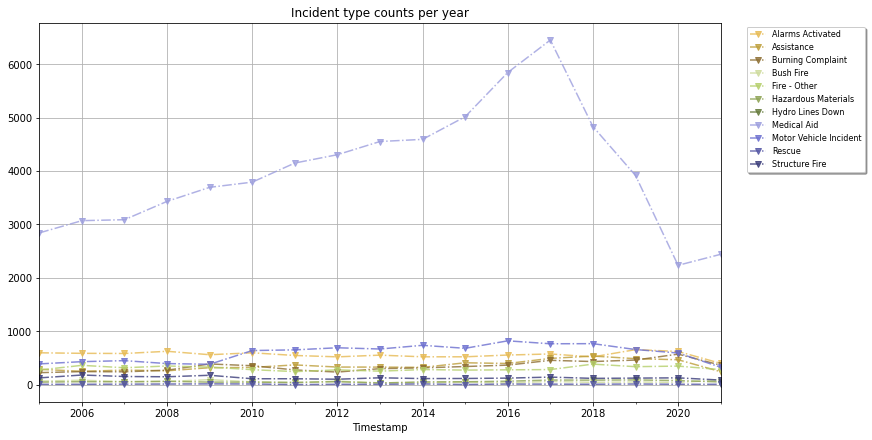

In [85]:
# include plot per category in Description
fig_count = plt.figure(figsize=(12,6), constrained_layout=True)
ax_count_ = plt.subplot(111)
fig_count.add_subplot(ax_count_)
#
cmap = cm.get_cmap('tab20b') # chose a qualitative colormap
colors = [cmap(i)[:-1]+tuple([0.8]) for i , s in enumerate(process.df['Description'].cat.categories)][::-1]
#
for i, c in enumerate(process.df['Description'].cat.categories):
    catser = process.df['Description'][process.df['Description']==c].resample('y').count()
    catser.plot(ax=ax_count_,
           marker='v',
           color = colors[i],
           linestyle='dashdot',
           title='Incident type counts per {}'.format('year'),
           label='{}'.format(c)
           )
    ax_count_.legend(loc='upper center', shadow=True, fontsize=8, bbox_to_anchor=(1.125, 1.))
    ax_count_.grid(True)

It is clear that the yearly count is highly influenced by the 'Medical Aid' category. It drives the aforementioned decline. The number of calls keeps being stable during the years for the rest of categories in spite of the growing population.

Let's see a monthly counts chart per category in order to better understand each of these.

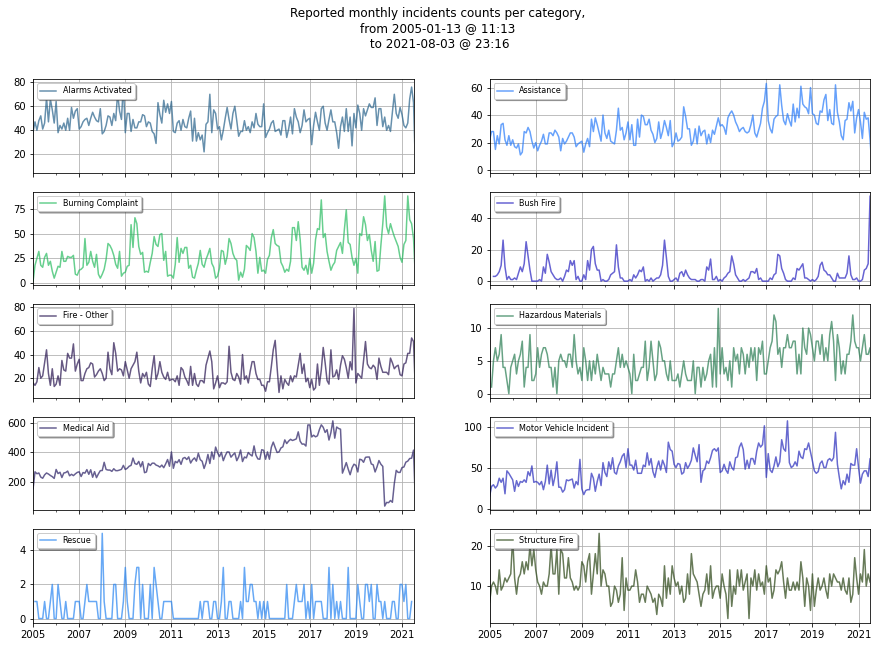

In [82]:
# do not include medical aid
fig_count, ax_count_e = plt.subplots(5, 2, sharex=True, figsize=(15, 10))
#fig_count = plt.figure(figsize=(12,10), constrained_layout=True)
fig_count.suptitle('Reported {}ly incidents counts per category,\nfrom {}\n to {}'.format(sampling, process.df.index.min().strftime('%Y-%m-%d @ %H:%M'), process.df.index.max().strftime('%Y-%m-%d @ %H:%M')), fontsize=12)
#
i=1
for c in process.df['Description'].cat.categories:
    if c != 'Hydro Lines Down':
        catser = process.df['Description'][process.df['Description']==c].resample(sampling[0]).count()
        # plot counter
        ax_count_e = plt.subplot(5, 2, i)
        fig_count.add_subplot(ax_count_e)

        catser.plot(ax=ax_count_e,
               #marker='+',
               #linestyle='dashdot',
               color=(0.15, 0.75*random.random(), random.random(), 0.7),
               #title='Incident type counts per {} (excluding "Medical Aid")'.format(sampling),
               label='{}'.format(c)
               )
        ax_count_e.legend(loc='upper left', shadow=True, fontsize=8)# bbox_to_anchor=(1.125, 1.))
        ax_count_e.grid(True)
        ax_count_e.set_xlabel(None)
        i+=1


The pandemic definitely impacted the number of calls except for the category *'Bush Fire'*, being the only incident type with a small increase during this year. How related to COVID would that be?

## Credits

[City Of Nanaimo](https://www.nanaimo.ca/)

Jeff Jacob - Thank you for your help and guidance through the schema changes and kudos on the [Fire Incidence online App](https://www.nanaimo.ca/fire-rescue-incidents/)

Ivan Mendivelso - Thank you for your patience and help reviewing this document.

## License

[MIT](https://choosealicense.com/licenses/mit/)